# Inference Kernel Demo

This is the kernel I’ve used for my recent submissions. It takes about 5-6 hours on the test set, using only CPU. 

I’ve provided this kernel because a lot of people have problems making submissions. This method works and has never errored out for me. (Although I haven't tried making a submission using the GPU yet -- so no guarantees there.)

It uses BlazeFace for face extraction (see also [my BlazeFace kernel](https://www.kaggle.com/humananalog/starter-blazeface-pytorch)) and ResNeXt50 as the classifier model.

We take the average prediction over 17 frames from each video. (Why 17? Using more frames makes the kernel slower, but doesn't appear to improve the score much. I used an odd number so we don't always land on even frames.)

**Please use this kernel only to learn from...** Included is the checkpoint for a ResNeXt50 model that hasn't really been trained very well yet. I'm sure you can improve on it by training your own model!

You could use the included trained weights to get yourself an easy top-50 score on the leaderboard (as of 24 Jan 2020) but it’s nicer to use it as a starting point for your own work. :-)

In [3]:
import os, sys, time
import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Get the test videos

In [4]:
test_dir = "./data/test_videos"

test_videos = sorted([x for x in os.listdir(test_dir) if x[-4:] == ".mp4"])
len(test_videos)

400

## Create helpers

In [5]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 1.4.0
CUDA version: 10.1
cuDNN version: 7603


In [6]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

In [ ]:
# from blazeface import BlazeFace
# face_detector = BlazeFace().to(gpu)
# face_detector.load_weights("./blazeface.pth")
# face_detector.load_anchors("./anchors.npy")
# _ = face_detector.train(False)

In [7]:
from facenet_pytorch import MTCNN

In [8]:
mtcnn = MTCNN(margin=20, keep_all=True, post_process=False, device='cuda:0')
face_detector = mtcnn

In [9]:
class VideoReader():
    def __init__(self, frames_per_video=24):
        self.frames_per_video = frames_per_video
        
    def read_frames(self, video_path):
        frames = []
        capture = cv2.VideoCapture(video_path)

        success = 1
        count = 0

        while success: 

            success, frame = capture.read() 
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            #frame = cv2.resize(frame, (128, 128))

            frames.append(frame)

            count += 1
            
            if count >= self.frames_per_video:
                return frames            
        capture.release()
        return frames

In [10]:
# from helpers.read_video_1 import VideoReader
# from helpers.face_extract_1 import FaceExtractor

frames_per_video = 10

video_reader = VideoReader(frames_per_video=frames_per_video)
video_read_fn = lambda x: video_reader.read_frames(x)

In [11]:
## quick test
video_path = os.path.join('./data/test_videos', test_videos[1])

In [ ]:
len(video_read_fn(video_path))

In [12]:
class FaceExtractor():
    def __init__(self, video_read_fn, face_detector):
        self.video_read_fn = video_read_fn
        self.face_detector = face_detector
        
    def keep_only_best_face(self, faces):
        faces = torch.max(torch.stack(faces, dim=0), axis=1).values
        for face in faces:
            face = face[:4]
        return faces
        
    def process_video(self, video_path):
        frames = self.video_read_fn(video_path)
        faces = []
        for frame in frames:
            faces.append(self.face_detector(frame))
            
        return faces, frames

In [13]:
face_extractor = FaceExtractor(video_read_fn, face_detector)

In [14]:
input_size = 224

In [15]:
from torchvision.transforms import Normalize

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)

## Creating an Ensemble

In [16]:
import torch.nn as nn
import torchvision.models as models

class MyResNeXt(models.resnet.ResNet):
    def __init__(self, training=True):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3], 
                                        groups=32, 
                                        width_per_group=4)
        self.fc = nn.Sequential(nn.Dropout(0.6),nn.Linear(2048, 1))
def add_fc_layer(model):
    model.fc = nn.Sequential(nn.Dropout(0.8),nn.Linear(2048, 1))
    return model

In [17]:
# checkpoint = models.resnet.resnext50_32x4d(pretrained=True).state_dict()

model = MyResNeXt().to(gpu)
model.load_state_dict(torch.load('./image-classifier-blur-checkpoint.pth'))

_ = model.eval()

# del checkpoint

In [18]:
model2 = models.wide_resnet101_2(pretrained=True)
model2 = add_fc_layer(model2)
model2 = model2.to(gpu)

model2.load_state_dict(torch.load('./widerresnext-flip-checkpoint.pth'))
_ = model2.eval()

## Test Runs

In [16]:
def plot_detections(faces):
    fig, axes = plt.subplots(1, len(faces))
    for face, ax in zip(faces, axes):
        ax.imshow(face.permute(1, 2, 0).int().numpy())
        ax.axis('off')
    fig.show()

In [19]:
video_path = os.path.join('./data/test_videos', test_videos[2])

In [20]:
def read_frame(video_path):
    capture = cv2.VideoCapture(video_path)
    ret, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #frame = cv2.resize(frame, (128, 128))
    capture.release()
    return frame

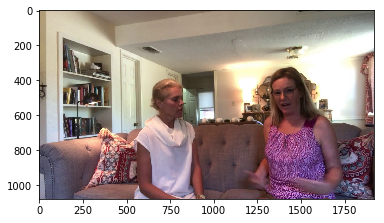

In [21]:
frame = read_frame(video_path)
plt.imshow(frame)

In [20]:
detections = face_detector(frame)

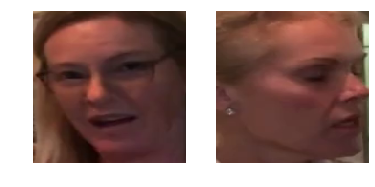

In [25]:
plot_detections(detections)

In [168]:
detections, frames = face_extractor.process_video(video_path)

In [167]:
type(detections)

list

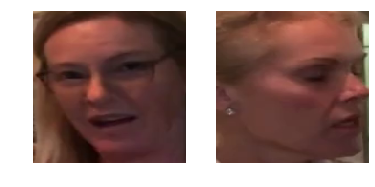

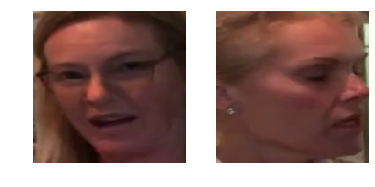

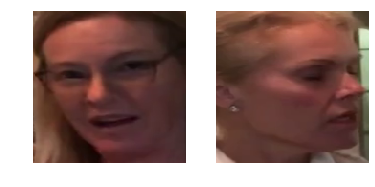

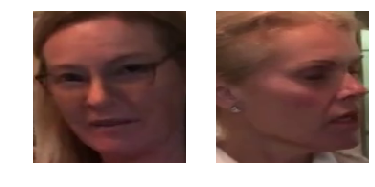

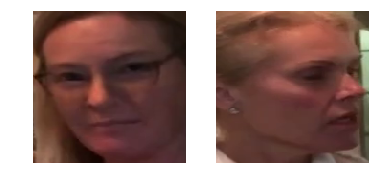

In [169]:
for index, frame in enumerate(frames[:5]):
    plot_detections(detections[index])

In [48]:
print(np.shape(detections[0]))

torch.Size([2, 3, 160, 160])


## Prediction loop

In [22]:
def predict_on_video(video_path, batch_size):
    #o=0
    try:
        # Find the faces for N frames in the video.
        faces, frames = face_extractor.process_video(video_path)
        # Only look at one face per frame.
        #faces = face_extractor.keep_only_best_face(faces)

        #looking at all faces in a frame
        #print("len",len(faces))
        #o=o+1
        if len(faces) > 0:
            # NOTE: When running on the CPU, the batch size must be fixed
            # or else memory usage will blow up. (Bug in PyTorch?)
            face_size=0
            for face in (faces):
                if(face is None):
                    face_size = face_size
                else:
                    for single_face in face:
                        face_size += 1

            x = np.zeros((face_size, input_size, input_size, 3), dtype=np.uint8)
            y = np.zeros((face_size, input_size, input_size, 3), dtype=np.uint8)
            #print('face_size',face_size)
            # If we found any faces, prepare them for the model.
            n = 0
            for face in (faces):
                # Resize to the model's required input size.
                # We keep the aspect ratio intact and add zero
                # padding if necessary.     
                #face = crop_face(frames[index], face)
                #face = np.array(face)
                #q = 0
                if face is None:
                    n = n
                else:
                    for single_face in face:
                        #print('q',q)
                        #q=q+1
                        single_face = single_face.permute(1, 2, 0).int().numpy()
                        single_face = np.array(single_face)
                        #print(np.shape(single_face))
                        # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
                        # ax1.axis('off')
                        # ax1.imshow(single_face, cmap=plt.cm.gray)
                        # ax1.set_title('Modified image')
                        # ax2.axis('off')
                        # ax2.imshow(single_face, cmap=plt.cm.gray)
                        # ax2.set_title('original face')
                        # plt.show()
                        #resized_face = isotropically_resize_image(single_face, input_size)
                        #print("here")
                        #resized_face = make_square_image(resized_face)
                        resized_face = cv2.resize(single_face.astype('float32'), (input_size, input_size),interpolation=cv2.INTER_AREA)
                        #print("where")
                        
                        x[n] = resized_face
                        #Put augumentation code here
                        y[n] = cv2.GaussianBlur(x[n],(5,5),0,3)
                        n += 1
                    
                
               
                # Test time augmentation: horizontal flips.
                # TODO: not sure yet if this helps or not
                #x[n] = cv2.flip(resized_face, 1)
                #n += 1
            #print('n',n)
            if n > 0:
                x = torch.tensor(x, device=gpu).float()
                y = torch.tensor(x, device=gpu).float()
                #print(x.size())
                # Preprocess the images.
                x = x.permute((0, 3, 1, 2))
                y = y.permute((0, 3, 1, 2))

                for i in range(len(x)):
                    x[i] = normalize_transform(x[i] / 255.)
                    y[i] = normalize_transform(y[i] / 255.)
                # Make a prediction, then take the average.
                with torch.no_grad():
                    y_pred1 = model(y)
                    y_pred1 = torch.sigmoid(y_pred1.squeeze())
                    y_pred2 = model2(x)
                    y_pred2 = torch.sigmoid(y_pred2.squeeze())
                    y_pred = (y_pred1+y_pred2)/2
                    #print(y_pred)
                    y_pred,indices = torch.sort(y_pred,descending = True)
                    if n<5 and n>1:
                        return y_pred[:n].mean().item()
                    if n==1:
                        return y_pred
                    else:
                        return y_pred[:5].mean().item()

    except Exception as e:
        print("Prediction error on video %s: %s" % (video_path, str(e)))

    return 0.5

In [23]:
predict_on_video(video_path, frames_per_video)

0.9983782172203064

In [46]:
y_pred = predict_on_video(os.path.join(train_dir, 'axwgcsyphv.mp4'), batch_size=frames_per_video)

In [47]:
y_pred

tensor(0.9163, device='cuda:0')

In [24]:
from concurrent.futures import ThreadPoolExecutor

def predict_on_video_set(videos, num_workers, data_dir=test_dir):
    def process_file(i):
        filename = videos[i]
        y_pred = predict_on_video(os.path.join(data_dir, filename), batch_size=frames_per_video)
        return y_pred

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        predictions = ex.map(process_file, range(len(videos)))

    return list(predictions)

## Evaluation

In [25]:
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, classification_report

In [26]:
train_dir = "./data/train_sample_videos" ## One sample of training data

metadata = pd.read_json('./data/train_sample_videos/metadata.json').T
metadata

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4
...,...,...,...
etejaapnxh.mp4,FAKE,train,wtreibcmgm.mp4
etmcruaihe.mp4,FAKE,train,afoovlsmtx.mp4
etohcvnzbj.mp4,FAKE,train,bdnaqemxmr.mp4
eudeqjhdfd.mp4,REAL,train,None


In [27]:
train_videos = list(list(metadata.index))
len(train_videos)

400

In [28]:
y_truth = list((metadata['label'] == 'FAKE').astype(np.int))
# sanity check
sum(y_truth)

323

In [29]:
predictions = predict_on_video_set(train_videos, num_workers=5, data_dir=train_dir)

In [30]:
y_truth, predictions = np.array(y_truth), np.array(predictions)

In [31]:
# Compute ROC curve and ROC area
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_truth, predictions)
roc_auc = auc(fpr, tpr)

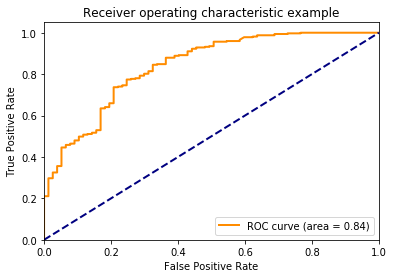

In [32]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [33]:
threshold = 0.5
pred_labels = np.where(predictions < threshold, 0, 1)

In [34]:
accuracy_score(y_truth, pred_labels)

0.8675

In [36]:
print(classification_report(y_truth, pred_labels, target_names=["FAKE", "REAL"]))

precision    recall  f1-score   support

        FAKE       0.82      0.40      0.54        77
        REAL       0.87      0.98      0.92       323

    accuracy                           0.87       400
   macro avg       0.84      0.69      0.73       400
weighted avg       0.86      0.87      0.85       400



In [ ]:
# Loss:
def get_bce_loss(predictions, y_truth):
    predictions = torch.Tensor(list(predictions)).to(gpu).float()
    y_truth =  torch.Tensor(list(y_truth)).to(gpu).float()

    return F.binary_cross_entropy_with_logits(predictions, y_truth).cpu().detach().numpy()

get_bce_loss(predictions, y_truth)

## Speed test

The leaderboard submission must finish within 9 hours. With 4000 test videos, that is `9*60*60/4000 = 8.1` seconds per video. So if the average time per video is greater than ~8 seconds, the kernel will be too slow!

In [41]:
speed_test = True # you have to enable this manually

In [42]:
if speed_test:
    start_time = time.time()
    speedtest_videos = test_videos[:5]
    predictions = predict_on_video_set(speedtest_videos, num_workers=4)
    elapsed = time.time() - start_time
    print("Elapsed %f sec. Average per video: %f sec." % (elapsed, elapsed / len(speedtest_videos)))

Elapsed 11.418394 sec. Average per video: 2.283679 sec.


## Make the submission

In [43]:
predictions = predict_on_video_set(test_videos[:2], num_workers=4)

In [ ]:
predictions

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def play_video(video_file):
    '''
    Display video
    param: video_file - the name of the video file to display
    param: subset - the folder where the video file is located (can be TRAIN_SAMPLE_FOLDER or TEST_Folder)
    '''
    video_url = open(os.path.join('./data/test_videos', video_file),'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(video_url).decode()
    return HTML("""<video width=500 controls><source src="%s" type="video/mp4"></video>""" % data_url)

In [ ]:
play_video(test_videos[0])

In [44]:
predictions[0]

0.9641159176826477